In [43]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

random_state = 137 # Joe is a physician.

%matplotlib inline

## Reading and Cleaning

In [2]:
df = pd.read_excel('default of credit card clients.xls', skiprows=1, index_col='ID')
df.rename({'default payment next month': 'default'}, axis=1, inplace=True)

In [3]:
# Combine other small categories  
df.loc[(df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0), 'EDUCATION'] = 4

In [4]:
# Combine to have 1:married, 2:single, 3:other
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3

In [5]:
df.rename({'PAY_0': 'pay_stat_sep', 'PAY_2': 'pay_stat_aug', 'PAY_3': 'pay_stat_jul', 'PAY_4': 'pay_stat_jun', 'PAY_5': 
           'pay_stat_may', 'PAY_6': 'pay_stat_apr'}, axis=1, inplace=True)

In [6]:
for col in df.columns:
    df.rename({'{}'.format(col): '{}'.format(col.lower())}, axis=1, inplace=True)

## EDA

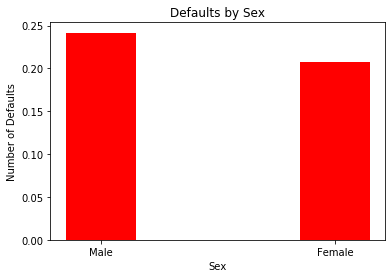

In [10]:
p1 = plt.bar(
    ['Male', 'Female'],
    [df.default.loc[df['sex']==1].value_counts()[1]/sum(df['sex']==1), 
     df.default.loc[df['sex']==2].value_counts()[1]/sum(df['sex']==2)], 
    color='r', width=0.3)

plt.title("Defaults by Sex")
plt.ylabel('Number of Defaults')
plt.xlabel('Sex')
plt.show()

Text(0.5, 1.0, 'Percentage Defaults by Education Status')

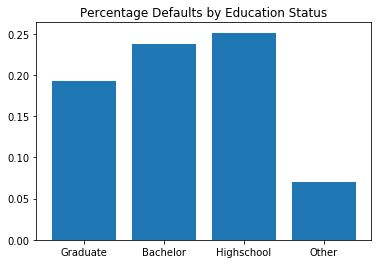

In [22]:
education_df = df.groupby(['education', 'default']).size()
nums = []
for i in range(1,5):
    values = []
    for j in range(0,2):
        if j == 0:
            values.append(education_df[i][j]/(education_df[i][j] + education_df[i][j+1]))
        if j == 1:
            values.append(education_df[i][j]/(education_df[i][j] + education_df[i][j-1]))
    nums.append(values)  
edu_defaults = [x[1] for x in nums]
plt.bar(['Graduate', 'Bachelor', 'Highschool', 'Other'], edu_defaults);
plt.title('Percentage Defaults by Education Status')

## Feature Engineerin'

In [25]:
months = ['sep', 'aug', 'jul', 'jun', 'may', 'apr']
for i, c in enumerate(months):
    df[f'deferred_payment_{c}'] = np.where(df[f'pay_stat_{c}']<=0, 0, 1)

In [26]:
df['last_month_v_limit'] = df['bill_amt1']/df['limit_bal']

In [27]:
df = pd.get_dummies(df, columns=['marriage', 'sex', 'education'], drop_first=True)

In [28]:
for i in range(2,7):
    df.drop(columns = [f'bill_amt{i}', f'pay_amt{i}'], axis = 1, inplace=True)
    

In [29]:
for month in months:
    df.drop(columns=f'pay_stat_{month}', axis=1, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 18 columns):
limit_bal               30000 non-null int64
age                     30000 non-null int64
bill_amt1               30000 non-null int64
pay_amt1                30000 non-null int64
default                 30000 non-null int64
deferred_payment_sep    30000 non-null int64
deferred_payment_aug    30000 non-null int64
deferred_payment_jul    30000 non-null int64
deferred_payment_jun    30000 non-null int64
deferred_payment_may    30000 non-null int64
deferred_payment_apr    30000 non-null int64
last_month_v_limit      30000 non-null float64
marriage_2              30000 non-null uint8
marriage_3              30000 non-null uint8
sex_2                   30000 non-null uint8
education_2             30000 non-null uint8
education_3             30000 non-null uint8
education_4             30000 non-null uint8
dtypes: float64(1), int64(11), uint8(6)
memory usage: 3.1 MB


## Splittin' 'n' Smotin'

In [31]:
X = df.drop(columns='default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

In [32]:
smiter = SMOTE(random_state=random_state, n_jobs=-1)

In [33]:
X_train_sm, y_train_sm = smiter.fit_resample(X_train, y_train)

In [34]:
len(X_train_sm)-len(X_train), len(y_train_sm)- len(y_train)

(12550, 12550)

In [35]:
scaler= MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [36]:
scaler_sm = MinMaxScaler()

X_train_sm_sc = scaler_sm.fit_transform(X_train_sm)
X_test_sm_sc = scaler_sm.transform(X_test)

### To smote or not to smote - A logistic tale

//anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.760220956080267

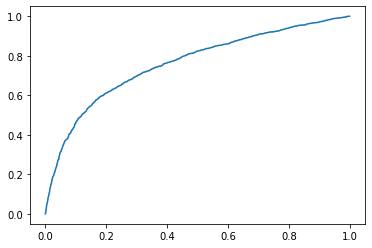

In [37]:
log_reg = LogisticRegression(random_state=random_state)

log_model = log_reg.fit(X_train_sc, y_train)

y_hat_log = log_model.predict_proba(X_test_sc)[:,1]


fpr,tpr,thr = roc_curve(y_test, y_hat_log)

sns.lineplot(fpr,tpr)

auc(fpr, tpr)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.763040956824706

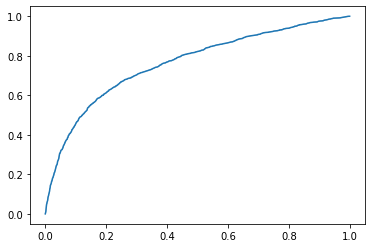

In [45]:
log_reg_sm = LogisticRegression(random_state=random_state)

log_model_sm = log_reg.fit(X_train_sm_sc, y_train_sm)

y_hat_log_sm = log_model_sm.predict_proba(X_test_sc)[:,1]

y_pred_log_sm = log_model_sm.predict(X_test_sc)

fpr,tpr,thr = roc_curve(y_test, y_hat_log_sm)

sns.lineplot(fpr,tpr)

auc(fpr, tpr)

In [46]:
report = classification_report(y_test, y_pred_log_sm)

In [47]:
print(report)

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      5839
           1       0.49      0.58      0.53      1661

    accuracy                           0.77      7500
   macro avg       0.68      0.71      0.69      7500
weighted avg       0.79      0.77      0.78      7500



So we sm.

## Beyond LogReg

### SVC - Easy as do re mi

### KNN

In [49]:
knn = KNeighborsClassifier(n_neighbors=1) #baseline
knn.fit(X_train_sm_sc, y_train_sm)

knn_probs = knn.predict_proba(X_test_sm_sc)[:,1]

roc_auc_score(y_test, knn_probs)

0.6029735387008757

In [50]:
knn_grid = KNeighborsClassifier(n_jobs=-1)

param_grid_knn = {
    'n_neighbors':range(4, 10),
    'weights':['uniform', 'distance'], 
    'p':range(5,8)
}

opt_model_knn = GridSearchCV(knn_grid, param_grid_knn, cv=5, scoring='roc_auc')
opt_model_knn.fit(X_train_sm_sc, y_train_sm)
best_model_knn = opt_model_knn.best_estimator_

opt_model_knn.best_params_

{'n_neighbors': 7, 'p': 6, 'weights': 'distance'}

In [53]:
knn_grid_probs = best_model_knn.predict_proba(X_test_sm_sc)[:,1]
roc_auc_score(y_test, knn_grid_probs)

0.7008952033076187

### Random Forest

In [54]:
random_forest = RandomForestClassifier(n_estimators=100)

In [55]:
random_forest.fit(X_train_sm_sc, y_train_sm)

forest_probs = random_forest.predict_proba(X_test_sm_sc)[:,1]

roc_auc_score(y_test, forest_probs)

0.7457691997972075

In [ ]:
random_forest_grid = {
    'max_depth':range(8, 12+1),
    'min_samples_leaf':[10,15,20]
}

opt_model_rf = GridSearchCV(random_forest, random_forest_grid, cv=5 ,scoring='roc_auc')
opt_model_rf.fit(X_train_sm_sc, y_train_sm)

In [58]:
best_model_rf = opt_model_rf.best_estimator_

opt_model_rf.best_params_

{'max_depth': 12, 'min_samples_leaf': 10}

In [60]:
forest_grid_probs = best_model_rf.predict_proba(X_test_sm_sc),1]

roc_auc_score(y_test, forest_grid_probs)

0.778613650515194